This notebook contains a very simple example of how to analyze your videos using flytracker (name will change). It's very minimal, but all you need to get started.

In [1]:
import torch
from flytracker import run
from flytracker.analysis import annotate
from flytracker.utils.param_helpers import load_frame, test_mask, test_threshold, test_blob_detector
from flytracker.localization.blob import default_blob_detector_params
import matplotlib.pyplot as plt

In [2]:
# Location of movie
movie_path = "../data/experiments/bruno/videos/seq_1.mp4"

The videos often contain the edges of the plate and sometimes QR codes. These mess with the detection, so we remove them by applying a mask. To check if we're using the right mask, we load a random frame, apply our mask and see how it looks. Let's use frame 100:

In [3]:
image = load_frame(movie_path, frame=100, color=False)

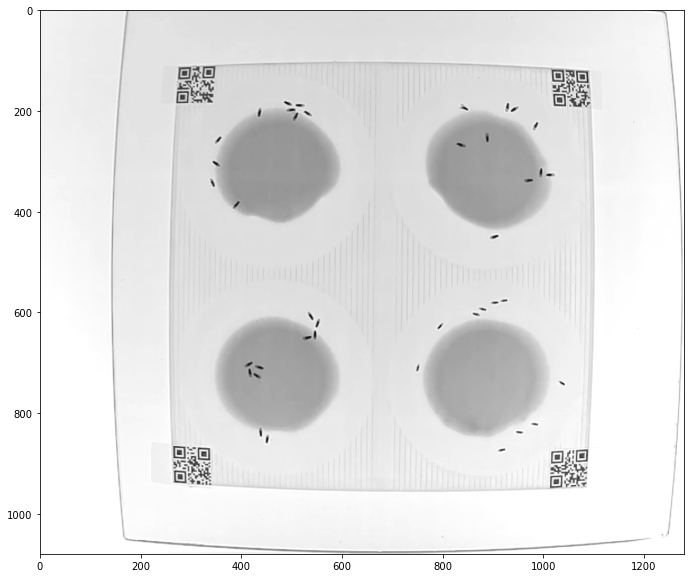

In [4]:
plt.figure(figsize=(15, 10))
plt.imshow(image, cmap='gray')

The mask is just an array of 1s and 0s with the same size of as the image, and 0 meaning we don't want to use the area. Below is how we build it, and we apply it to image

In [5]:
mask = torch.ones((1080, 1280), dtype=bool)
mask[:130, :] = 0
mask[-160:, :] = 0
mask[:, :270] = 0
mask[:, -205:] = 0

mask[:190, :350] = 0
mask[:195, -270:] = 0
mask[-220:, :340] = 0
mask[870:, 1010:] = 0

masked_image = test_mask(image, mask)

Let's see how it looks;

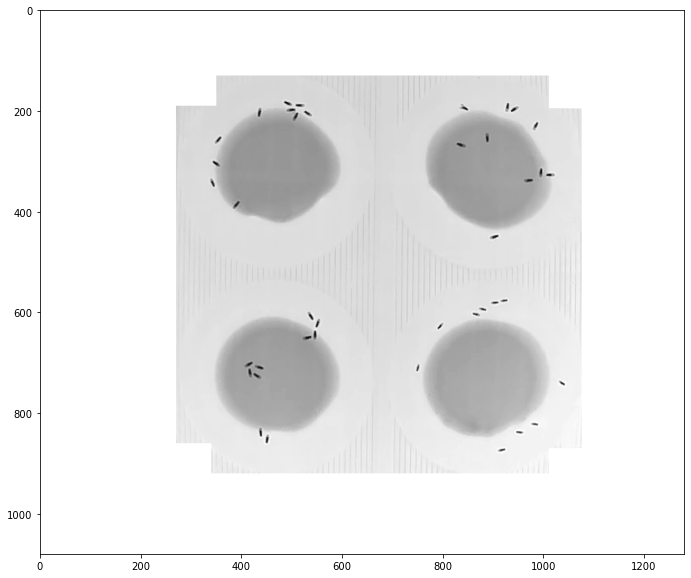

In [6]:
plt.figure(figsize=(15, 10))
plt.imshow(masked_image, cmap='gray')

Once the mask is good, we can check the blob detector, which decides how many flies and initializes the kmeans. We've chosen good defaults, but if you use very different setting (for example, 20 arenas), you might have to change them.

In [7]:
positions = test_blob_detector(masked_image, default_blob_detector_params())

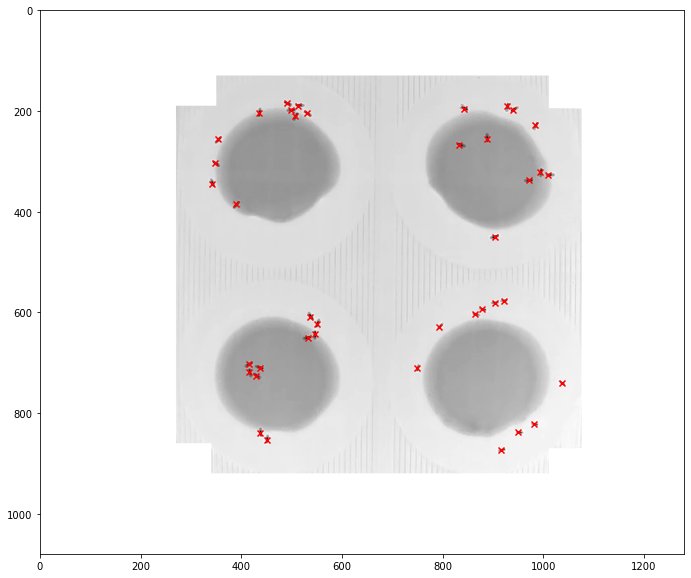

In [8]:
plt.figure(figsize=(15, 10))
plt.imshow(masked_image, cmap='gray')
plt.scatter(*positions[:, ::-1].T, marker="x", color="r")

Seems good. We also need to threshold the image to decide where the flies are. Typically we choose 120 as a threshold value which works well in most cases, but again, you might need to change a bit.

In [9]:
threshold = 120
thresholded_image = test_threshold(masked_image, threshold)

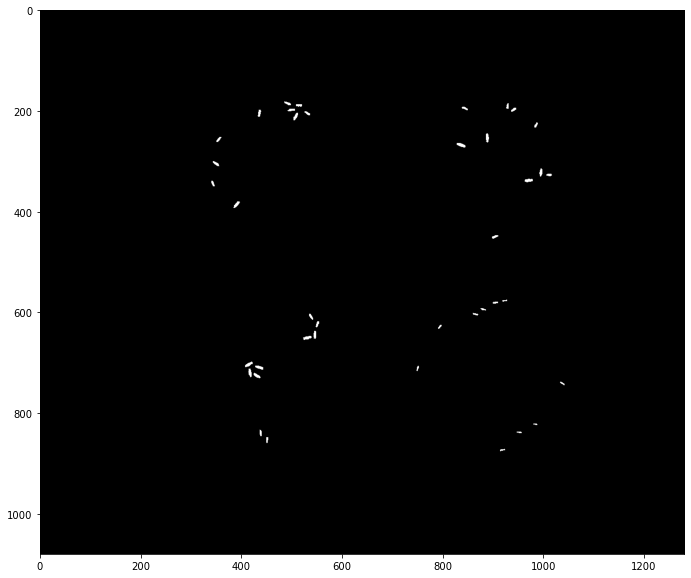

In [10]:
plt.figure(figsize=(15, 10))
plt.imshow(thresholded_image, cmap='gray')

Looks good again. We just need to supply the movie location, mask, and number of arenas. THe settings are if you want to use a GPU (3x speedup), parallel load, how many initial frames for the blob detector and the threshold. Most won't need to be changed.

In [ ]:
%%time
df = run(
    movie_path,
    mask,
    n_arenas=4,
    gpu=True,
    parallel=True,
    n_ini=100,
    threshold=threshold,
)

Done with frame 0
Done with frame 1000
Done with frame 2000
Done with frame 3000
Done with frame 4000
Done with frame 5000
Done with frame 6000
Done with frame 7000
Done with frame 8000
Done with frame 9000
Done with frame 10000


We save the dataframe to hdf using high compression; so that it doesn't become really big.

In [39]:
df.to_hdf("../tests/df.hdf", key="df", complevel=9, complib="blosc")

Finally you can annotate, just give the dataframe and the movie location. Track_length says how long you want the paths to persist in seconds, and touching distance gives you a warning if flies get closer than this distance. 

Annotating is pretty slow, so I'd only do it to manually check if you see weird stuff in your trajectories or you're validating.

In [40]:
annotate(df, movie_path, "../tests/annotated_video.mp4", track_length=30, touching_distance=10,)

Done with frame 1000
Done with frame 2000
Done with frame 3000
Done with frame 4000
Done with frame 5000
